In [ ]:
import enum
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_code


## 1. Define the structure of facilities


In [ ]:
# Year we want to visualize.
YEAR = 2022
# Year we want to compare with (need not be the previous year).
YEAR_TO_COMPARE = 2021
# Amount of emissions per one square.
SQUARE_VALUE_MT = 0.25


class SquareTypes(enum.Enum):
    ELECTRICITY_HEAT = "EH"
    STEEL = "S"
    RAFINERY = "R"
    LIMEWORKS_CEMENTWORKS = "LC"


definition = [
    {"facility_id": 1,
     "name": "Elektrárna Počerady, a.s.",
     "permit_id": {"CZ-0204-05": SquareTypes.ELECTRICITY_HEAT,
                   "CZ-0478-12": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 2,
     "name": "ArcelorMittal Ostrava a TAMEH Czech",
     "permit_id": {"CZ-0134-05": SquareTypes.STEEL,
                   "CZ-0444-10": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 3,
     "name": "Třinecké železárny a Energetika Třinec",
     "permit_id": {"CZ-0192-05": SquareTypes.STEEL,
                   "CZ-0101-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 4,
     "name": "Elektrárna Ledvice",
     "permit_id": {"CZ-0447-11": SquareTypes.ELECTRICITY_HEAT,
                   "CZ-0201-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 5,
     "name": "Rafinerie Litvínov",
     "permit_id": {"CZ-0400-05": SquareTypes.RAFINERY,
                   "CZ-0160-05": SquareTypes.RAFINERY,
                   "CZ-0231-05": SquareTypes.RAFINERY},
     },
    {"facility_id": 6,
     "name": "Elektrárna Prunéřov",
     "permit_id": {"CZ-0207-05": SquareTypes.ELECTRICITY_HEAT,
                   "CZ-0206-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 7,
     "name": "Elektrárna Tušimice",
     "permit_id": {"CZ-0209-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 8,
     "name": "Elektrárna Chvaletice",
     "permit_id": {"CZ-0200-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 9,
     "name": "Elektrárna Mělník",
     "permit_id": {"CZ-0202-05": SquareTypes.ELECTRICITY_HEAT,
                   "CZ-0092-05": SquareTypes.ELECTRICITY_HEAT,
                   "CZ-0203-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 10,
     "name": "Teplárna Vřesová",
     "permit_id": {"CZ-0197-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 11,
     "name": "Teplárna Kladno",
     "permit_id": {"CZ-0148-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 12,
     "name": "Elektrárna Opatovice",
     "permit_id": {"CZ-0080-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 13,
     "name": "Elektrárna Dětmarovice",
     "permit_id": {"CZ-0198-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 14,
     "name": "Teplárna Komořany",
     "permit_id": {"CZ-0190-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 15,
     "name": "Elektrárna Třebovice",
     "permit_id": {"CZ-0317-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 16,
     "name": "Českomoravský cement (Mokrá)",
     "permit_id": {"CZ-0260-15": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {"facility_id": 17,
     "name": "Elektrárna Tisová",
     "permit_id": {"CZ-0208-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 18,
     "name": "Plzeňská teplárenská",
     "permit_id": {"CZ-0121-05": SquareTypes.ELECTRICITY_HEAT,
                   "CZ-0138-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 19,
     "name": "Cement Hranice",
     "permit_id": {"CZ-0136-05": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {"facility_id": 20,
     "name": "CEMEX Czech Republic",
     "permit_id": {"CZ-0381-05": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {"facility_id": 21,
     "name": "Rafinerie Kralupy",
     "permit_id": {"CZ-0372-05": SquareTypes.RAFINERY},
     },
    {"facility_id": 22,
     "name": "Elektrárna Trmice",
     "permit_id": {"CZ-0237-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 23,
     "name": "Lafarge Cement",
     "permit_id": {"CZ-0193-05": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {"facility_id": 24,
     "name": "Českomoravský cement (Radotín)",
     "permit_id": {"CZ-0261-15": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {"facility_id": 25,
     "name": "Elektrárna Kralupy",
     "permit_id": {"CZ-0259-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 26,
     "name": "Vápenka Čertovy schody",
     "permit_id": {"CZ-0144-05": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {"facility_id": 27,
     "name": "Teplárna Mladá Boleslav",
     "permit_id": {"CZ-0256-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 28,
     "name": "Mondi Štětí",
     "permit_id": {"CZ-0147-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 29,
     "name": "Elektrárna Poříčí",
     "permit_id": {"CZ-0205-05": SquareTypes.ELECTRICITY_HEAT},
     },
    {"facility_id": 30,
     "name": "Vápenka Vitošov",
     "permit_id": {"CZ-0178-05": SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
]


## 2. Load data (with minor adjustments)


In [ ]:
def fix_allowance_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={"value": "MtCO2eq"}) \
        .drop("MAIN_ACTIVITY_TYPE_CODE", axis=1)


In [ ]:
allowances_df = fix_allowance_df(
    get_allowances_data(
        YEAR, "CZ", None, "../data/EUA/verified_emissions_2022_en.xlsx"
    )
)
allowances_df.head(1)


,MtCO2eq,IDENTIFIER_IN_REG
PERMIT_IDENTIFIER,,
CZ-0204-05,5.14253,"Elektrárna Počerady, a.s."


## 3. Add facility details to the data frame


In [8]:
def _map_permit_id_to_facility_id(permit_id: str) -> int:
    for facility in definition:
        if permit_id in facility["permit_id"]:
            return facility["facility_id"]


def _map_permit_id_to_square_type(permit_id: int) -> str:
    for facility in definition:
        if permit_id in facility["permit_id"]:
            return facility["permit_id"][permit_id].value


def _map_facility_id_to_facility_name(facility_id: int) -> str:
    for facility in definition:
        if facility_id == facility["facility_id"]:
            return facility["name"]


def add_facility_details(df: pd.DataFrame) -> None:
    """Map permit to facility id, facility name and to square type """
    # Find and add square_type to an allowance
    df["square_type"] = df.index.to_series().apply(_map_permit_id_to_square_type)
    # Find and add facility_id to an allowance
    df["facility_id"] = df.index.to_series().apply(_map_permit_id_to_facility_id)
    # Find and add facility_name to an allowance
    df["facility_name"] = df["facility_id"].apply(_map_facility_id_to_facility_name)


In [9]:
top_30 = allowances_df.copy()
# Add facility id, name and square types.
add_facility_details(top_30)
# Select only the top30 facilities (i.e. those that have a facility_id defined).
top_30 = top_30[top_30.facility_id.notna()]
# Remove decimals from facility_id
top_30["facility_id"] = top_30["facility_id"].astype(int)
top_30.head(2)


,MtCO2eq,IDENTIFIER_IN_REG,square_type,facility_id,facility_name
PERMIT_IDENTIFIER,,,,,
CZ-0204-05,5.142530,"Elektrárna Počerady, a.s.",EH,1,"Elektrárna Počerady, a.s."
CZ-0200-05,4.555826,Elektrárna Chvaletice a.s.,EH,8,Elektrárna Chvaletice


## 4. Create emissions pivot table with columns per square type


In [10]:
def create_pivot_df_grouped_by_facility_id(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group by `facility_id` and `square_type` and sum `MtCO2eq` emissions by type, then pivot by
    `facility_id`, turning individual square types to columns.
    """
    df = df.groupby(["facility_id", "square_type"]).sum().round(2)
    df = pd.pivot_table(
        df, index=["facility_id"], columns="square_type", values="MtCO2eq", fill_value=0)
    df.astype(int)
    return df


In [11]:
pivot_df = create_pivot_df_grouped_by_facility_id(top_30)
pivot_df.head(3)


square_type,EH,LC,R,S
facility_id,,,,
1,5.88,0.0,0.0,0.00
2,1.78,0.0,0.0,2.38
3,1.54,0.0,0.0,2.49


## 5. Add back facility name and total emissions, add square counts


In [13]:
def create_df_facility_emision_value(df):
    """Group by facility_id and name_id, sum  MtCO2eq emisions by facility"""
    df = df.drop(["IDENTIFIER_IN_REG", "square_type"], axis=1)
    return df.groupby(["facility_id", "facility_name"]).sum().round(2)

def add_squares_count(df) -> None:
    """Computes and adds squares for the total emissions and per emissions type as new columns"""
    df["sq_TOTAL"] = (df["MtCO2eq"] / SQUARE_VALUE_MT).round().astype(int)
    for square_type in SquareTypes:
        df[f"sq_{square_type.value}"] = (df[(square_type.value)] / SQUARE_VALUE_MT).round().astype(int)


In [14]:
# Group by facility_id, sum emmisions, compute total squares.
facility_emission_value_df = create_df_facility_emision_value(top_30)
df_output = facility_emission_value_df.join(pivot_df)
# Add squares count (total and per each type).
add_squares_count(df_output)
# Make a copy of df and replace zeros in the copy for better legibility
df_output_to_view = df_output.copy()
df_output_to_view.replace(0, "-", inplace=True)
df_output_to_view


,,MtCO2eq,EH,LC,R,S,sq_TOTAL,sq_EH,sq_S,sq_R,sq_LC
facility_id,facility_name,,,,,,,,,,
1,"Elektrárna Počerady, a.s.",5.88,5.88,-,-,-,24,24,-,-,-
2,ArcelorMittal Ostrava a TAMEH Czech,4.16,1.78,-,-,2.38,17,7,10,-,-
3,Třinecké železárny a Energetika Třinec,4.03,1.54,-,-,2.49,16,6,10,-,-
4,Elektrárna Ledvice,3.05,3.05,-,-,-,12,12,-,-,-
5,Rafinerie Litvínov,3.67,-,-,3.67,-,15,-,-,15,-
6,Elektrárna Prunéřov,3.52,3.52,-,-,-,14,14,-,-,-
7,Elektrárna Tušimice,3.39,3.39,-,-,-,14,14,-,-,-
8,Elektrárna Chvaletice,4.56,4.56,-,-,-,18,18,-,-,-
9,Elektrárna Mělník,2.35,2.35,-,-,-,9,9,-,-,-


## 6. Create a df for the previous year situation to find out the changes


In [ ]:
# Repeat the same for the comparison data frame.

# 1. Get the data
compare_allowances_df = fix_allowance_df(
    get_allowances_data(
        YEAR_TO_COMPARE, "CZ", None, "../data/EUA/verified_emissions_2021_en.xlsx"
    )
)
# 2. Add facility details
add_facility_details(compare_allowances_df)
# 3. Create emissions pivot table
compare_pivot_df = create_pivot_df_grouped_by_facility_id(compare_allowances_df)
# 4. Add back facility name and total emissions, add square counts
compare_facility_emission_value_df = create_df_facility_emision_value(compare_allowances_df)
compare_df_output = compare_facility_emission_value_df.join(compare_pivot_df)
add_squares_count(compare_df_output)

compare_df_output.head(3)


,,MtCO2eq,EH,LC,R,S,sq_TOTAL,sq_EH,sq_S,sq_R,sq_LC
facility_id,facility_name,,,,,,,,,,
1.0,"Elektrárna Počerady, a.s.",5.39,5.39,0.0,0.0,0.00,22,22,0,0,0
2.0,ArcelorMittal Ostrava a TAMEH Czech,5.12,2.04,0.0,0.0,3.08,20,8,12,0,0
3.0,Třinecké železárny a Energetika Třinec,4.04,1.51,0.0,0.0,2.53,16,6,10,0,0


## 7. Compute table to see the changes in comparison with the chosen year


In [17]:
diff_df = df_output.subtract(compare_df_output)

# Filter out items with no difference
zero_condition = diff_df["sq_TOTAL"] == 0.0
for square_type in SquareTypes:
  zero_condition &= diff_df[f"sq_{square_type.value}"] == 0.0

# Make a copy of df and replace zeros in the copy for better legibility
diff_df_to_view = diff_df[~zero_condition].copy()
diff_df_to_view.replace(0, "-", inplace=True)
diff_df_to_view

,,MtCO2eq,EH,LC,R,S,sq_TOTAL,sq_EH,sq_S,sq_R,sq_LC
facility_id,facility_name,,,,,,,,,,
1,"Elektrárna Počerady, a.s.",0.49,0.49,-,-,-,2,2,-,-,-
2,ArcelorMittal Ostrava a TAMEH Czech,-0.96,-0.26,-,-,-0.7,-3,-1,-2,-,-
4,Elektrárna Ledvice,-0.73,-0.73,-,-,-,-3,-3,-,-,-
8,Elektrárna Chvaletice,1.16,1.16,-,-,-,4,4,-,-,-
9,Elektrárna Mělník,-0.04,-0.04,-,-,-,-1,-1,-,-,-
10,Teplárna Vřesová,-0.44,-0.44,-,-,-,-2,-2,-,-,-
11,Teplárna Kladno,0.15,0.15,-,-,-,1,1,-,-,-
12,Elektrárna Opatovice,-0.22,-0.22,-,-,-,-1,-1,-,-,-
13,Elektrárna Dětmarovice,-0.10,-0.1,-,-,-,-1,-1,-,-,-


## 8. Check top 10 allowances which did not make it to the "top 30" facilities.


In [18]:
# Join all permit ids from the top-30 definition into one list.
permit_ids = []
for facility in definition:
  permit_ids += list(facility["permit_id"].keys())

# Drop allowances in top 30.
below_thirty_df = allowances_df[~allowances_df.index.isin(permit_ids)].copy()

# Group , compute squares, remove decimals from "squares"
below_thirty_df["squares"] = (below_thirty_df["MtCO2eq"] / SQUARE_VALUE_MT).round().astype(int)

below_thirty_df.head(10)

,MtCO2eq,IDENTIFIER_IN_REG,squares
PERMIT_IDENTIFIER,,,
CZ-0085-05,0.328676,Teplárna Otrokovice - Teplárna,1
CZ-0321-05,0.292206,Veolia Energie - Teplárna Olomouc,1
CZ-0284-05,0.262952,Teplárna České Budějovice,1
CZ-0235-05,0.254285,DEZA - teplárna závodu,1
CZ-0091-05,0.251768,Teplárna Zlín s.r.o.,1
CZ-0328-05,0.241709,Veolia Energie - Teplárna Karviná,1
CZA-003-10,0.240924,"Smartwings, a.s.",1
CZ-0048-05,0.231506,Synthesia - odštěpný závod SYNTHESIA,1
CZ-0181-05,0.191623,Lovochemie - Uhelná kotelna,1


## 9. Charts and texts


In [20]:
def percentage(part, whole):
    return (part / whole) * 100

def draw_barh_charts (df):
    color = ["dimgrey", "silver"]
    df_charts.plot.barh(stacked=True, color=color, legend=False)

    # Upper chart
    plt.text(part_2 - 62, 0.91, f"{part_1:.0f} %", size=30, color="silver")
    plt.text(0,1.3, f"Podíl emisních povolenek na celkových ročních emisí ČR v roce {YEAR}.", size=15)

    # lower chart
    plt.text(part_1 - 33, -0.075,f"{part_2:.0f} %", size=30, color="silver");
    plt.text(0,0.3, f"Emitenti zobrazení v mapě odpovídají za {part_2:.0f} % emisí z těchto povolenek.", size=15)

    # Both charts
    plt.axis("off")


In [21]:
# Fetch total emissions data
df_emis = get_eurostat_crf_data_for_code("TOTX4_MEMONIA", YEAR)

# Variables
cr_total = df_emis.loc["CZ","value"]  # Total CR emissions for chosen year, MtCO2eq.
cr_allow = allowances_df["MtCO2eq"].sum()  # Total emissions covered by allowances for chosen year, MtCO2eq.
cr_emit_in_map = df_output["MtCO2eq"].sum()  # Total emissions displayed in map for chosen year, MtCO2eq.

# Compute percentage
part_1 = percentage(cr_allow, cr_total)  # Allowances in % relative to CR.
part_2 = percentage(cr_emit_in_map, cr_allow)  # Emitters in map in % relative to allowances emissions.
part_3 = percentage(cr_emit_in_map, cr_total)  # Emitters in map in % relative to CR.


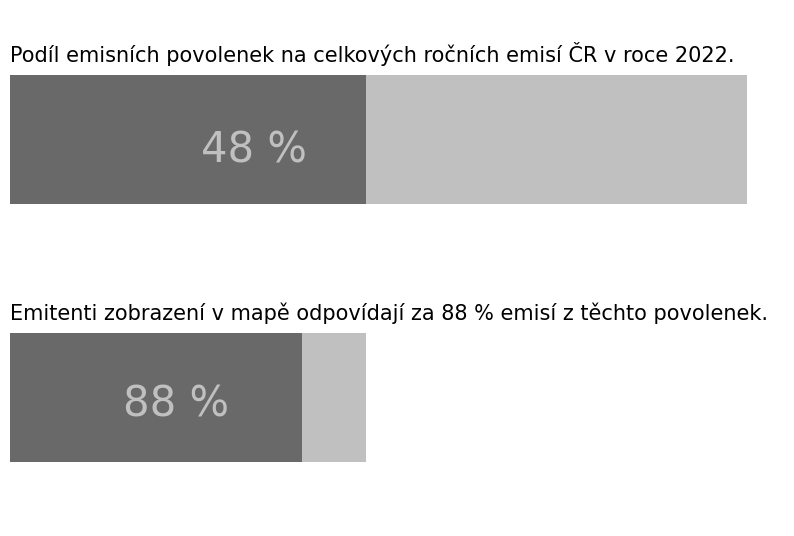

In [25]:
# Create df as a source for the charts.
data_charts = {
    "allowances": [part_2 - part_1, part_1],
    "other": [part_1 - (part_2 - part_1), 100 - part_1]
}
df_charts = pd.DataFrame(data_charts, index=["CR_2", "CR_rel"])

# Draw charts
draw_barh_charts(df_charts)


In [26]:
# Print chart description
print(f"""
Horní graf:
- Celkové množství emisí ČR v roce {YEAR} činí {cr_total:.1f} Mt CO2eq.
- Emisní povolenky pokrývají {part_1:.0f} % celkových ročních emisí ČR za rok {YEAR}."

Dolní graf:
- Emitenti zobrazení v mapě odpovídají za {part_2:.0f} % emisí z těchto povolenek. To odpovídá {part_3:.0f} % všech emisí v ČR.
""")


Horní graf:
- Celkové množství emisí ČR v roce 2022 činí 118.5 Mt CO2eq.
- Emisní povolenky pokrývají 48 % celkových ročních emisí ČR za rok 2022."

Dolní graf:
- Emitenti zobrazení v mapě odpovídají za 88 % emisí z těchto povolenek. To odpovídá 43 % všech emisí v ČR.



In [28]:
# Print backing texts
print(f"""
Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů v České republice – elektrárny a teplárny, ocelárny, cementárny a rafinerie. Zobrazení emitenti představují {part_2:.0f} % emisí pokrytých emisními povolenkami ze systému EU ETS pro Českou republiku a celkově {part_3:.0f} % ročních emisí skleníkových plynů České republiky.

U každého zdroje je znázorněno množství emisí, jeden čtvereček odpovídá 250 000 t CO2eq. Barvy odlišují jednotlivá zařízení podle typu hlavní aktivity: elektrárny a teplárny, vápenky a cementárny, rafinérie, železárny a ocelárny. V oblasti Západních Čech je nakumulována většina zařízení určených k výrobě elektřiny a tepla, zatímco v Moravskoslezském kraji jsou hlavními emitenty podniky určené k výrobě železa a oceli. Významným zdrojem emisí CO2 jsou také cementárny, jejichž celkový příspěvek v roce {YEAR} činil {df_output["LC"].sum().round(1)} Mt CO2eq.

Pro přehlednost jsme u některých zdrojů sloučili více různých emitentů registrovaných v systému ETS do jednoho zobrazeného celku. Např. Plzeňská teplárenská má zvlášť registrované dvě velké teplárny v různých částech města nebo mnohé elektrárny mají zvlášť registrované svoje jednotlivé bloky. Dále jsme přiřadili k hutním podnikům jejich teplárenské složky, protože jsou nutnou součástí jejich provozu (to je jisté zjednodušení, protože tyto teplárenské podniky část vyrobeného tepla či páry dodávají i externím zákazníkům).

Prakticky všechny zobrazené zdroje emisí produkují pouze CO2, jen rafinerie mohou vedle CO2 vytvářet další skleníkové plyny. V rámci systému obchodování s emisními povolenkami EU ETS i v naší grafice jsou jiné skleníkové plyny než oxid uhličitý převedeny na ekvivalentní množství CO2, označované CO2eq.

Nejvíce ze zobrazených zařízení vlastní ČEZ, další jsou ve vlastnictví Sev.en Energy, Skupiny TAURON a LIBERTY Steel Group.

Další poznámky:

Evropský ETS byl spuštěn v roce 2005 jako první mezinárodní systém pro obchodování s emisními povolenkami a pokrývá přibližně 40 % emisí skleníkových plynů v EU, především v sektorech energetiky, těžkého průmyslu a letectví. Data z EU ETS poskytují souhrnné údaje o emisích a povolenkách podle zemí, odvětví a roku a pocházejí hlavně z protokolu transakcí EU EUTL. Data jsou poskytována Evropskou komisí a spravována Evropskou agenturou pro životní prostředí.

Pro širší kontext si můžete prohlédnout uhelné elektrárny světa na interaktivní mapě, která mj. umožňuje i posun v čase. Odpoví na otázky typu kdy nastal uhelný boom v Číně nebo jak výkonné máme elektrárny třeba oproti Polsku.
""")



Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů v České republice – elektrárny a teplárny, ocelárny, cementárny a rafinerie. Zobrazení emitenti představují 88 % emisí pokrytých emisními povolenkami ze systému EU ETS pro Českou republiku a celkově 43 % ročních emisí skleníkových plynů České republiky.

U každého zdroje je znázorněno množství emisí, jeden čtvereček odpovídá 250 000 t CO2eq. Barvy odlišují jednotlivá zařízení podle typu hlavní aktivity: elektrárny a teplárny, vápenky a cementárny, rafinérie, železárny a ocelárny. V oblasti Západních Čech je nakumulována většina zařízení určených k výrobě elektřiny a tepla, zatímco v Moravskoslezském kraji jsou hlavními emitenty podniky určené k výrobě železa a oceli. Významným zdrojem emisí CO2 jsou také cementárny, jejichž celkový příspěvek v roce 2022 činil 3.3 Mt CO2eq.

Pro přehlednost jsme u některých zdrojů sloučili více různých emitentů registrovaných v systému ETS do jednoho zobrazeného celku. Např. Plzeňská tepláren